<a href="https://colab.research.google.com/github/Belvinbarasa/Eng.barasa/blob/main/BELVIN_BARASA_WANAMI_PROJECT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION

Kenya’s national debt has been a topic of economic discussion, influencing fiscal policies, international relations, and economic stability. This data science project aims to analyze Kenya’s debt trends over time, providing insights into its growth, composition, and potential impact on the economy. By leveraging data-driven techniques, we will uncover patterns, forecast future debt levels, and explore correlations with key economic indicators.

# OBJECTIVE

The primary goals of this project are:


*   To explore historical debt trends and identify key patterns.
*   To predict future debt levels using machine learning models (e.g., Facebook Prophet).

*   To analyze relationships between debt and economic indicators such as GDP, inflation, and interest rates.
*   To provide actionable insights for policymakers, economists, and financial analysts.





# Step 1 | Setup and Initialization

Step 1.1 | Importing Necessary Libraries

First of all, I will import all the necessary libraries that we will use throughout the project. This generally includes libraries for data manipulation, data visualization, and others based on the specific needs of the project:

In [ ]:
!pip install dask[complete] dask-ml --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 7.9 MB/s eta 0:00:00


In [ ]:
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
#Initialize Dask Client (single Machine Mode)
client = Client()
print(client)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:45685
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36153'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39459'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:45863 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45863
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:57658
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:46821 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:46821
INFO:distributed.core:Starting established connection to tcp://127

<Client: 'tcp://127.0.0.1:45685' processes=2 threads=2, memory=12.67 GiB>


In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

%matplotlib inline

In [ ]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [ ]:
import pandas as pd
import numpy as np


n_rows = 1_000_000
df = pd.DataFrame({
    "id": np.arange(n_rows),
    "value": np.random.randint(1, 100, n_rows),
    "category": np.random.choice(["A", "B", "C"], n_rows)
})
# Convert Pandas DataFrame to Dask DataFrame
ddf = dd.from_pandas(df, npartitions=10) # split into 10 partitions

In [ ]:
# Display the first few rows (lazy execution)
print(ddf.head())

# Get data types (metadata only, doesn't load full data)
print(ddf.dtypes)

# Perform filtering (Lazy Execution)
filtered_df = ddf[ddf["value"] > 50] #This line creates a filtered dataframe and assigns it to the variable 'filtered_df'

# Perform Aggregations (Lazy Execution)
grouped_ddf = ddf.groupby("category")["value"].mean()

# Compute results (trigger execution)
print(filtered_df.compute().head()) # Convert to Pandas for viewing # This line was changed to use 'filtered_df' which was previously assigned.
print(grouped_ddf.compute()) # Perform actual aggregation

   id  value category
0   0     96        A
1   1     59        C
2   2     93        B
3   3     60        B
4   4      5        A
id                    int64
value                 int64
category    string[pyarrow]
dtype: object
   id  value category
0   0     96        A
1   1     59        C
2   2     93        B
3   3     60        B
5   5     51        B
category
A    50.031958
B    50.034759
C    50.017192
Name: value, dtype: float64


In [ ]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Step 1.2 | Loading the Dataset

Next, I will load the dataset into a pandas DataFrame which will facilitate easy manipulation and analysis:

In [ ]:
df = pd.read_csv('/content/public-debt-ksh-million.csv', encoding="ISO-8859-1")

# Step 2 | Initial Data Analysis

# Step 2.1 | Dataset Overview

First I will perform a preliminary analysis to understand the structure and types of data columns:

In [ ]:
df.head(10)

,Year,Month,Domestic Debt,External Debt,Total,ds,y


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Year           0 non-null      int64         
 1   Month          0 non-null      object        
 2   Domestic Debt  0 non-null      float64       
 3   External Debt  0 non-null      object        
 4   Total          0 non-null      object        
 5   ds             0 non-null      datetime64[ns]
 6   y              0 non-null      float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 132.0+ bytes


Afterward, I am going to gain a thorough understanding of the dataset before proceeding to the data cleaning and transformation stages

### **Setting a Color Palette and Plotting Kenya’s Debt Trends**

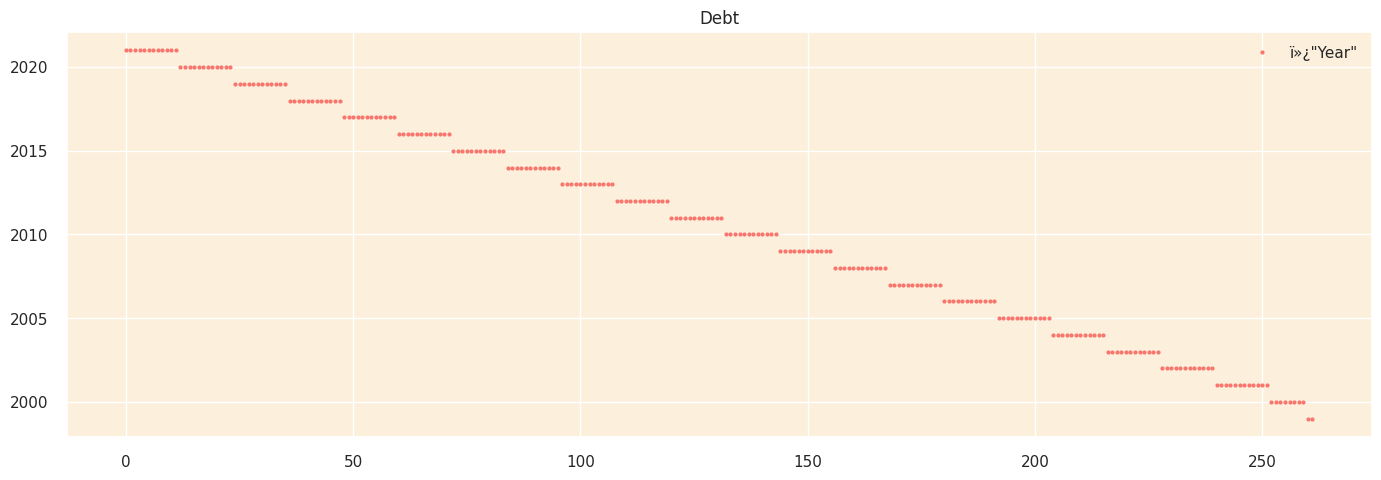

In [ ]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='Debt')
plt.show()


# 3 | Generating Time Series Features for Debt Analysis

This function create_features() is designed to extract time-based features from a DataFrame that has a datetime index. These features help in analyzing time series patterns in data, such as seasonality, trends, and periodic behavior of Kenya’s external debt.

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    # Convert the index to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)

    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    x = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:

        y = df[label]
        return x, y
    return x

x, y = create_features(df, label='External Debt')
features_and_target = pd.concat([x, y], axis=1)

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    # Convert the index to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)

    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    x = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        # Use the original label instead of converting to lowercase
        y = df[label]
        return x, y
    return x  # Return x, not X

x, y = create_features(df, label='External Debt') # Use the correct column name 'External Debt'
features_and_target = pd.concat([x, y], axis=1)

### **Displaying Extracted Time Series Features and Target Variable**

In [ ]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,External Debt
1970-01-01 00:00:00.000000000,0,3,1,1,1970,1,1,1,"4,174,371.53"
1970-01-01 00:00:00.000000001,0,3,1,1,1970,1,1,1,"4,109,282.85"
1970-01-01 00:00:00.000000002,0,3,1,1,1970,1,1,1,"4,083,124.54"
1970-01-01 00:00:00.000000003,0,3,1,1,1970,1,1,1,"4,062,504.78"
1970-01-01 00:00:00.000000004,0,3,1,1,1970,1,1,1,"4,054,862.85"


Renaming the First Column to 'date' in the Features and Target DataFrame

In [ ]:
features_and_target.rename(columns={features_and_target.columns[0]: 'date'}, inplace=True)


Displaying Column Names of the Features and Target DataFrame

In [ ]:
print(features_and_target.columns)  # Should now include 'ds'


Index(['date', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'External Debt'],
      dtype='object')


### **Converting the 'date' Column to Datetime Format**

In [ ]:
features_and_target['date'] = pd.to_datetime(features_and_target['date'])


### **Previewing the First Few Rows of the Features and Target DataFrame**

In [ ]:
features_and_target.head()


,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,External Debt
1970-01-01 00:00:00.000000000,1970-01-01,3,1,1,1970,1,1,1,"4,174,371.53"
1970-01-01 00:00:00.000000001,1970-01-01,3,1,1,1970,1,1,1,"4,109,282.85"
1970-01-01 00:00:00.000000002,1970-01-01,3,1,1,1970,1,1,1,"4,083,124.54"
1970-01-01 00:00:00.000000003,1970-01-01,3,1,1,1970,1,1,1,"4,062,504.78"
1970-01-01 00:00:00.000000004,1970-01-01,3,1,1,1970,1,1,1,"4,054,862.85"


### **Splitting the Data into Training and Test Sets Based on Year**

The code divides the dataset into training (df_train) and test (df_test) sets based on a split year (1970). This is a common practice in time series analysis to train models on past data and evaluate them on future data

In [ ]:
import pandas as pd

# Read the CSV file with the 'utf-8-sig' encoding to handle BOM
df = pd.read_csv('/content/public-debt-ksh-million.csv', encoding="utf-8-sig")

# Rename the column to 'Year' for easier access
df = df.rename(columns={'ï»¿"Year"': 'Year'})

# Now you can access the 'Year' column without issues
df['year'] = pd.to_datetime(df['Year'], format='%Y').dt.year

# Set 'Year' column as the index
df = df.set_index('Year')

# Now the comparison should work correctly, compare year as int
split_date = 1970
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

### **Visualizing the Train-Test Split for Debt Data**

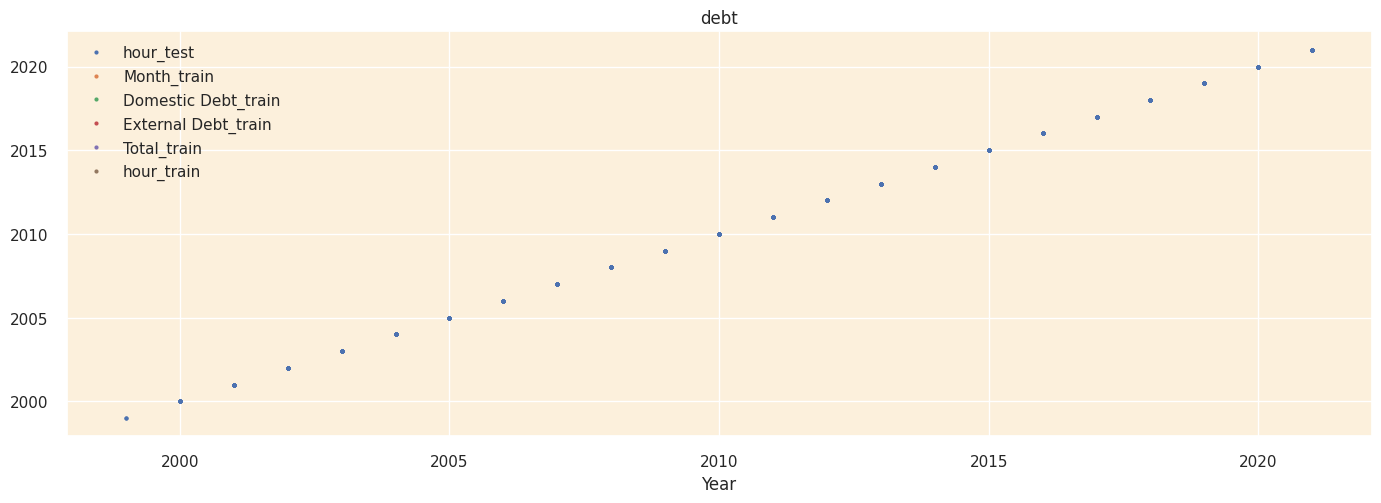

In [ ]:
# Plot train and test so you can see where we have split
df_test \
    .rename(columns={'year': 'hour'}) \
    .join(df_train.rename(columns={'year': 'hour'}),
          how='outer', lsuffix='_test', rsuffix='_train') \
    .plot(figsize=(15,5), title='debt', style='.')
plt.show()

### **Formatting Data for the Prophet Model with 'ds' and 'y' Columns**

In [ ]:
# Format data for prophet model using ds and y
df_train.reset_index() \
    .rename(columns={'External Debt':'ds',
                     'year':'y'}).head()

,Year,Month,Domestic Debt,ds,Total,y


In [ ]:
print(df_train.columns)


Index(['Month', 'Domestic Debt', 'External Debt', 'Total', 'year'], dtype='object')


In [ ]:
# Format data for prophet model using ds and y
df_train_prophet = df_train.reset_index() \
    .rename(columns={'date':'ds',
                     'External Debt':'y'})
print(df_train_prophet.head())
print(df_train_prophet.columns)

Empty DataFrame
Columns: [Year, Month, Domestic Debt, y, Total, year]
Index: []
Index(['Year', 'Month', 'Domestic Debt', 'y', 'Total', 'year'], dtype='object')


In [ ]:
print(df_train_prophet.dtypes)


Year              int64
Month            object
Domestic Debt    object
y                object
Total            object
year              int32
dtype: object


In [ ]:
df_train_prophet = df_train.reset_index() \
    .rename(columns={'date':'ds',
                     'External Debt':'y'}).head()

In [ ]:
# Format data for prophet model using ds and y
df_train_prophet = df_train.reset_index() \
    .rename(columns={'date':'ds',
                     'External Debt':'y'})

In [ ]:
# Format data for prophet model using ds and y
df_train_prophet = df_train.reset_index() \
    .rename(columns={'date':'ds',
                     'External Debt':'y'}).head()

In [ ]:
df_train_prophet = df_train.reset_index() \
    .rename(columns={'date': 'ds', 'External Debt': 'y'})

print(df_train_prophet.head())

Empty DataFrame
Columns: [Year, Month, Domestic Debt, y, Total, year]
Index: []


In [ ]:
print(df_train_prophet.isnull().sum())


Year             0
Month            0
Domestic Debt    0
y                0
Total            0
year             0
dtype: int64


In [ ]:
df_train_prophet = df_train_prophet.dropna()

In [ ]:
import pandas as pd

# Load the dataset
file_path = "/content/public-debt-ksh-million.csv"
df = pd.read_csv(file_path)

# Display the first few rows and column names
df.head(), df.columns

(   Year      Month Domestic Debt External Debt         Total
 0  2021   December  4,032,368.18  4,174,371.53  8,206,739.71
 1  2021   November  4,008,077.30  4,109,282.85  8,117,360.15
 2  2021    October  3,959,523.30  4,083,124.54  8,042,647.84
 3  2021  September  3,937,777.45  4,062,504.78  8,000,282.23
 4  2021     August  3,864,875.78  4,054,862.85  7,919,738.63,
 Index(['Year', 'Month', 'Domestic Debt', 'External Debt', 'Total'], dtype='object'))

In [ ]:
# Convert 'Month' to proper datetime format by combining with 'Year'
df['ds'] = pd.to_datetime(df['Month'] + ' ' + df['Year'].astype(str))

# Convert 'External Debt' to numeric (removing commas)
df['y'] = df['External Debt'].str.replace(',', '').astype(float)

# Select only the required columns
df_prophet = df[['ds', 'y']]

# Display the first few rows of the processed dataframe
df_prophet.head()

,ds,y
0,2021-12-01,4174371.53
1,2021-11-01,4109282.85
2,2021-10-01,4083124.54
3,2021-09-01,4062504.78
4,2021-08-01,4054862.85


4| ### **Generating Future Debt Predictions Using the Prophet Model**

In [ ]:
import pandas as pd
from prophet import Prophet

# Load the dataset
file_path = "/content/public-debt-ksh-million.csv"
df = pd.read_csv(file_path)

# Combine 'Year' and 'Month' into a single 'ds' column
df['ds'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')
# Assuming 'Month' is in format 'January', 'February', etc.

# Convert 'External Debt' to numeric
df['y'] = df['External Debt'].str.replace(',', '').astype(float)

# **Adjust split date to ensure sufficient training data**
split_date = 2000

# Split data into train and test sets
df_train = df[df['Year'] <= split_date].copy()
df_test = df[df['Year'] > split_date].copy()

# **Handle potential missing values**
df_train.dropna(subset=['y'], inplace=True) # Drop rows with missing 'y' values in training set

# Initialize and fit the Prophet model
model = Prophet()
model.fit(df_train[['ds', 'y']])  # Use only the necessary columns

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=len(df_test), freq='M')

# Make predictions
df_test_fcst = model.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4d_xgpr4/gxpb7wn6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4d_xgpr4/2eycmm25.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9918', 'data', 'file=/tmp/tmp4d_xgpr4/gxpb7wn6.json', 'init=/tmp/tmp4d_xgpr4/2eycmm25.json', 'output', 'file=/tmp/tmp4d_xgpr4/prophet_model3hdoowxp/prophet_model-20250331164911.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:49:11 - cmdstanpy - INFO - Chain [1] start processing
INF

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1999-09-01,324889.443478,303152.120133,345643.347710,324889.443478,324889.443478,0.0,0.0,0.0,0.0,0.0,0.0,324889.443478
1,1999-12-01,343284.922472,321757.883257,363663.877460,343284.922472,343284.922472,0.0,0.0,0.0,0.0,0.0,0.0,343284.922472
2,2000-03-01,361680.401777,339439.260367,382136.001288,361680.401777,361680.401777,0.0,0.0,0.0,0.0,0.0,0.0,361680.401777
3,2000-06-01,380278.028106,360835.461423,400684.442828,380278.028106,380278.028106,0.0,0.0,0.0,0.0,0.0,0.0,380278.028106
4,2000-07-01,386342.008060,362750.321169,407330.162684,386342.008060,386342.008060,0.0,0.0,0.0,0.0,0.0,0.0,386342.008060


### **Previewing the First Few Rows of the Forecasted Debt Data**

In [ ]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1999-09-01,324889.443478,303152.120133,345643.347710,324889.443478,324889.443478,0.0,0.0,0.0,0.0,0.0,0.0,324889.443478
1,1999-12-01,343284.922472,321757.883257,363663.877460,343284.922472,343284.922472,0.0,0.0,0.0,0.0,0.0,0.0,343284.922472
2,2000-03-01,361680.401777,339439.260367,382136.001288,361680.401777,361680.401777,0.0,0.0,0.0,0.0,0.0,0.0,361680.401777
3,2000-06-01,380278.028106,360835.461423,400684.442828,380278.028106,380278.028106,0.0,0.0,0.0,0.0,0.0,0.0,380278.028106
4,2000-07-01,386342.008060,362750.321169,407330.162684,386342.008060,386342.008060,0.0,0.0,0.0,0.0,0.0,0.0,386342.008060


### **Visualizing the Debt Forecast Using the Prophet Model**

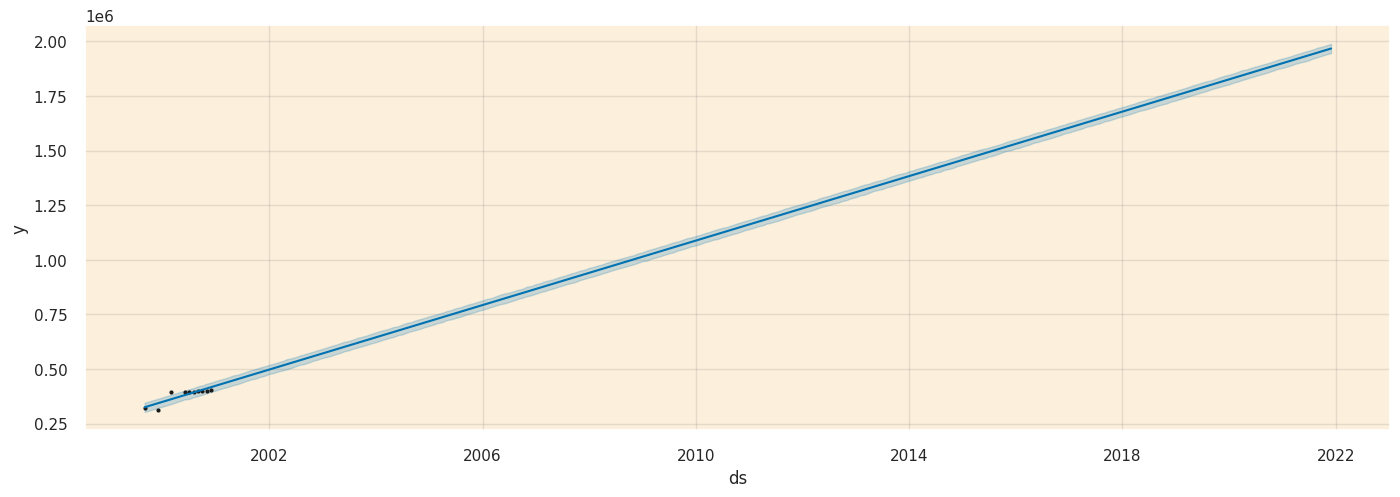

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_fcst,
                 ax=ax)
plt.show()

### **Analyzing the Components of the Prophet Model Forecast**

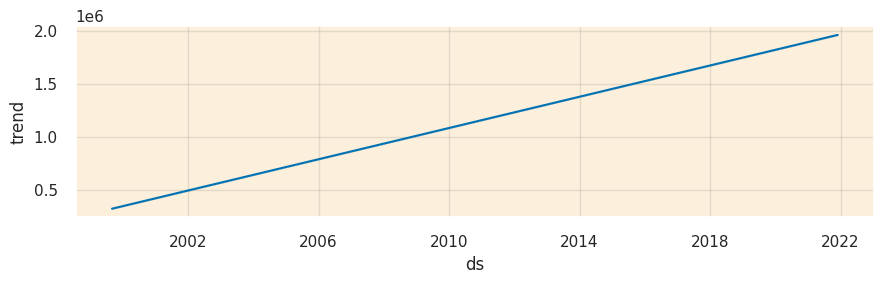

In [ ]:
# Plot the components of the model
fig = model.plot_components(df_test_fcst)

### **Comparing the Forecasted Debt with Actual Data**

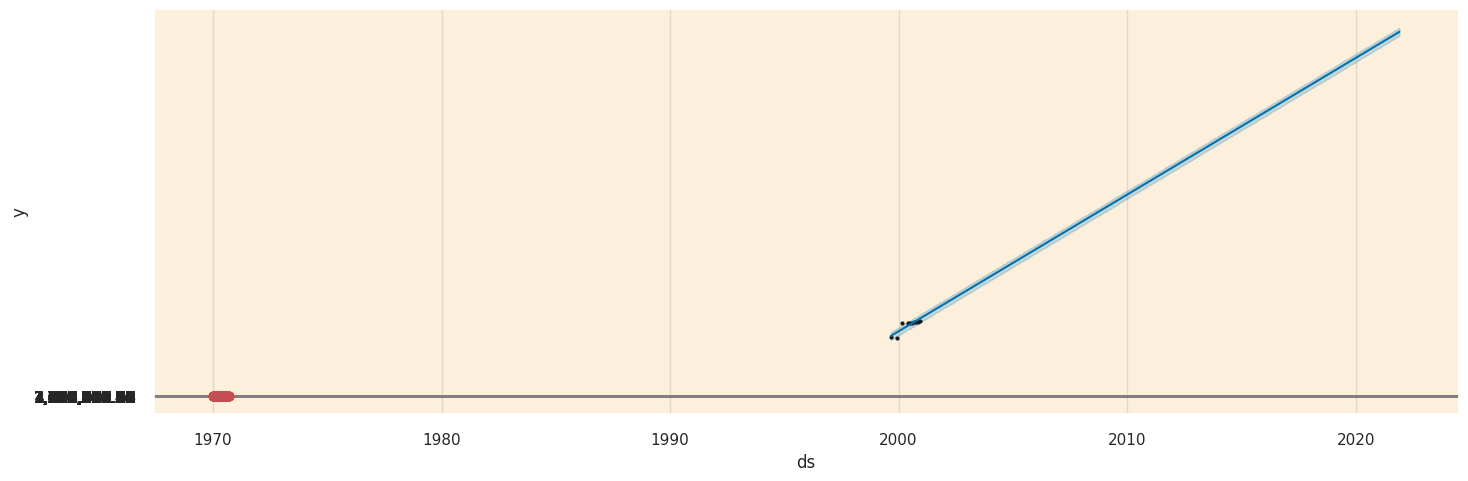

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
# Changed 'year' to 'Year' assuming it's the index or a column in df_test
ax.scatter(df_test.index, df_test['External Debt'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
plt.show()

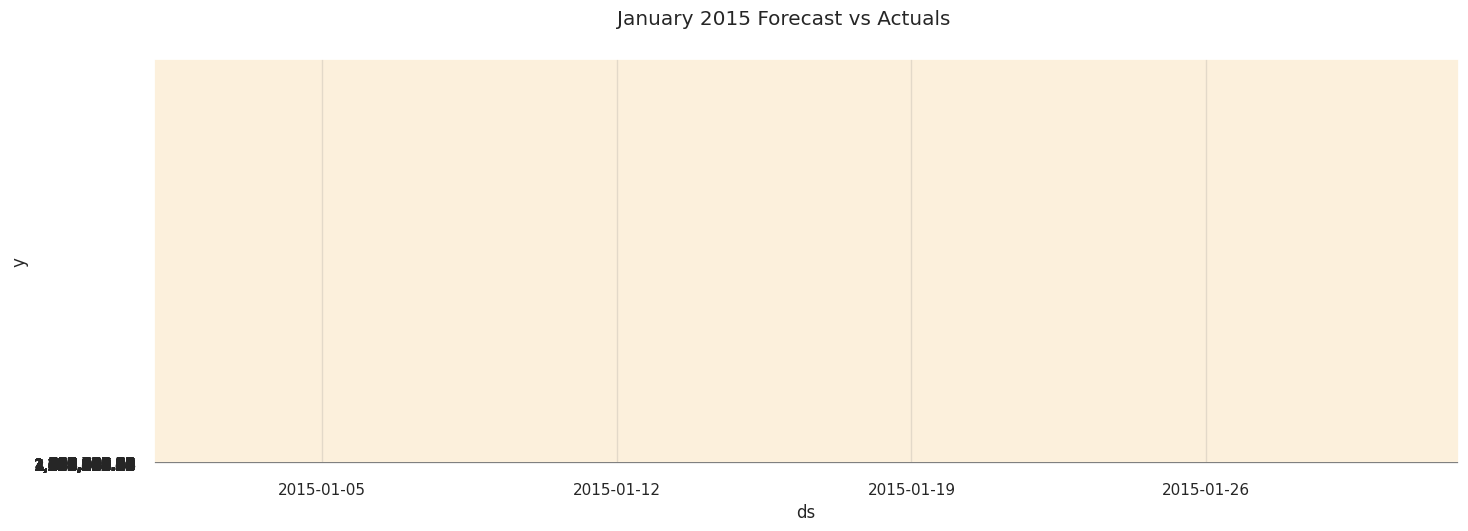

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

ax.scatter(df_test.index, df_test['External Debt'], color='r')

fig = model.plot(df_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2015'),
              upper=pd.to_datetime('02-01-2015'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')
plt.show()  # Add plt.show() to display the plot

### **Displaying the Index of the Test Data and Forecasted Dates**

Ensures consistency between actual test data (df_test.index) and forecasted dates (df_test_fcst['ds']).

Helps identify mismatches in date formatting or indexing that could affect model evaluation.

Useful for debugging forecasting issues if predictions don’t align with expected dates.

In [ ]:
print(df_test.index)
print(df_test_fcst['ds'])


DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004',
               '1970-01-01 00:00:00.000000005',
               '1970-01-01 00:00:00.000000006',
               '1970-01-01 00:00:00.000000007',
               '1970-01-01 00:00:00.000000008',
               '1970-01-01 00:00:00.000000009',
               ...
               '1970-01-01 00:00:00.000000242',
               '1970-01-01 00:00:00.000000243',
               '1970-01-01 00:00:00.000000244',
               '1970-01-01 00:00:00.000000245',
               '1970-01-01 00:00:00.000000246',
               '1970-01-01 00:00:00.000000247',
               '1970-01-01 00:00:00.000000248',
               '1970-01-01 00:00:00.000000249',
               '1970-01-01 00:00:00.000000250',
               '1970-01-01 00:00:00.000000251'],
              dtype=

In [ ]:
df_test.index = pd.to_datetime(df_test.index, errors='coerce')


In [ ]:
print(df_test_fcst['ds'].dt.year.unique())  # Forecast years
print(df_test.index.year.unique())         # Test set years


[1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2020 2021]
Index([1970], dtype='int32')


In [ ]:
df_test_fcst_subset = df_test_fcst[df_test_fcst['ds'].dt.year.isin(df_test.index.year)]


In [ ]:
df_test_fcst_subset = df_test_fcst[df_test_fcst['ds'].isin(df_test.index)]


In [ ]:
print(df_test_fcst_subset.shape)  # Should NOT be (0, X)
print(df_test_fcst_subset.head())


(0, 13)
Empty DataFrame
Columns: [ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat]
Index: []


In [ ]:
if not df_test_fcst_subset.empty:
    mse = mean_squared_error(y_true=df_test['External Debt'],
                             y_pred=df_test_fcst_subset['yhat'])
    print("MSE:", mse)
else:
    print("Error: No matching forecast values found.")


Error: No matching forecast values found.


# 4 | ### **Calculating Mean Absolute Error (MAE) by Merging Forecasted and Actual Debt Data**

In [ ]:
# Assuming df_test is indexed by 'Year' and 'External Debt' is the target column
# Extract the relevant portion of the forecast corresponding to the test set
# Convert df_test index to datetime objects if they are not already
df_test.index = pd.to_datetime(df_test.index, errors='coerce')  # Handle potential errors

# Ensure 'ds' column in df_test_fcst is also datetime objects
df_test_fcst['ds'] = pd.to_datetime(df_test_fcst['ds'])

# Convert 'External Debt' to numeric before merging if it is not already numeric
if not pd.api.types.is_numeric_dtype(df_test['External Debt']):
    df_test['External Debt'] = pd.to_numeric(df_test['External Debt'].str.replace(',', ''), errors='coerce')

# Filter forecast to match test data using the 'year' component of the dates
# Instead of using .isin(), we'll merge the DataFrames on the year
df_test_fcst_subset = pd.merge(
    df_test.reset_index()[['Year', 'External Debt']],
    df_test_fcst[['ds', 'yhat']],
    left_on='Year',
    right_on=df_test_fcst['ds'].dt.year,
    how='inner'  # Keep only common years
)

# Calculate the mean absolute error using the merged subset of the forecast
mae = mean_absolute_error(y_true=df_test_fcst_subset['External Debt'],
                       y_pred=df_test_fcst_subset['yhat'])  # Use the merged subset

print("MAE:", mae)  # Print the calculated MAE

MAE: 568944.9984327322


### **Calculating Mean Absolute Percentage Error (MAPE) for Forecast Evaluation**

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    # Convert to NumPy arrays if not already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Ensure both arrays have the same length
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    # Handle zero values in y_true to avoid division by zero
    y_true_nonzero = y_true[y_true != 0]
    y_pred_nonzero = y_pred[y_true != 0]

    # Calculate MAPE for non-zero values
    mape = np.mean(np.abs((y_true_nonzero - y_pred_nonzero) / y_true_nonzero)) * 100
    return mape

# Merge dataframes to align predictions with actuals based on 'ds'
merged_df = pd.merge(df_test, df_test_fcst[['ds', 'yhat']], left_on=df_test.index.to_series().dt.to_period('M'), right_on=df_test_fcst['ds'].dt.to_period('M'), how='inner')

# Calculate MAPE using the merged dataframe
mape = mean_absolute_percentage_error(y_true=merged_df['External Debt'], y_pred=merged_df['yhat'])

print("MAPE:", mape)

MAPE: nan


# 5 | ### **Creating and Computing with a Dask Array**

In [ ]:
# Create a large Dask Array (10 million elements, chunked)
arr = da.random.random(size=(10_000_000,), chunks=(1_000_000,))

# Compute mean and sum (Lazy until '.compute()' is called)
mean_value = arr.mean().compute()
sum_values = arr.sum().compute()

print("Mean:", mean_value)
print("Sum:", sum_values)

Mean: 0.5000399658941492
Sum: 5000399.658941492


In [ ]:
from dask_ml.linear_model import LinearRegression
# Crewate a synthetic dataset
X = da.random.random((10_000, 2), chunks=(1_000, 2))
y = da.random.random(10_000, chunks=(1_000,))
model = LinearRegression()

model.fit(X, y)
# Predict values
predictions = model.predict(X)
print(predictions.compute()[:5])

[0.5044502  0.5050575  0.50508335 0.50378518 0.50420929]


In [ ]:
client.close()

INFO:distributed.scheduler:Remove client Client-02501d53-0e4f-11f0-863b-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:57662; closing.
INFO:distributed.scheduler:Remove client Client-02501d53-0e4f-11f0-863b-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-02501d53-0e4f-11f0-863b-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1743439930.9911766') (0, 1)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:36153'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:39459'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:57660; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:46821 name: 0 (stimulus_id='handle-worker-cleanup-1743439931.0033672')
INFO:distr

# 6 | MISSING VALUES

### **Visualizing the Percentage of Missing Values for Each Column**

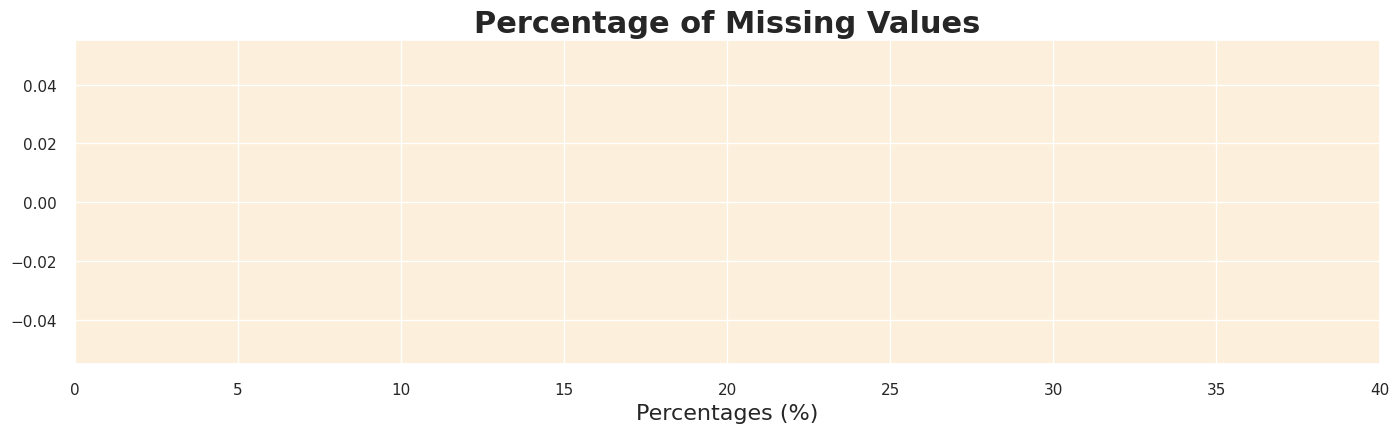

In [ ]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [ ]:
# Extracting rows with missing values, use actual column name
df[df['External Debt'].isnull() | df['Domestic Debt'].isnull()].head()

,Year,Month,Domestic Debt,External Debt,Total,ds,y


In [ ]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
df = df.dropna(subset=['External Debt', 'Domestic Debt'])

In [ ]:
# Verify the removal of missing values
df.isnull().sum().sum()

np.int64(0)

In [ ]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['External Debt', 'Domestic Debt'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

,Year,Month,Domestic Debt,External Debt,Total,ds,y


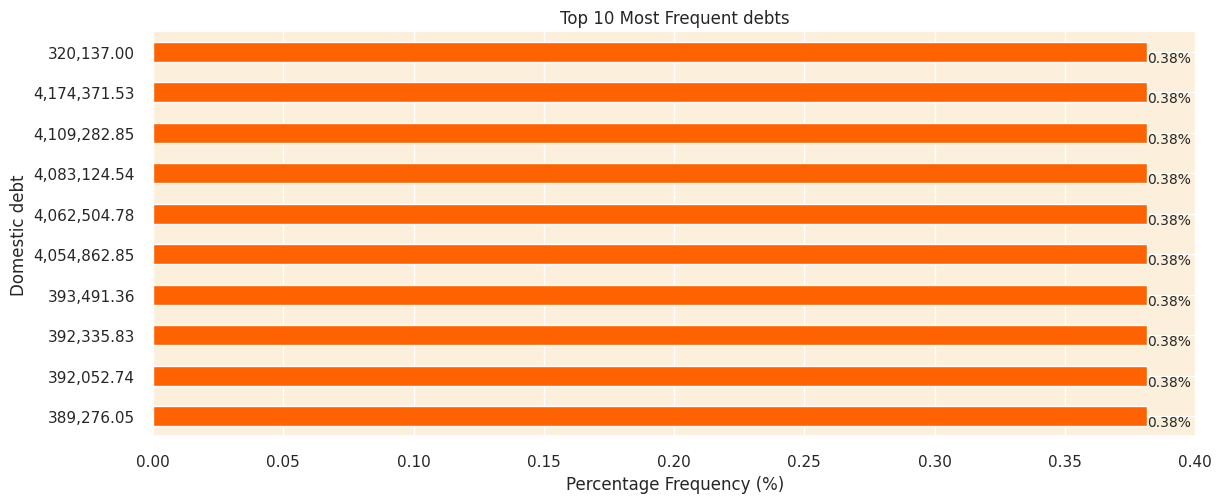

In [ ]:
# Load the dataset
file_path = "/content/public-debt-ksh-million.csv"
df = pd.read_csv(file_path)

# Display the first few rows and column names
df.head(), df.columns

# Convert 'Month' to proper datetime format by combining with 'Year'
df['ds'] = pd.to_datetime(df['Month'] + ' ' + df['Year'].astype(str))

# Convert 'External Debt' to numeric (removing commas)
df['y'] = df['External Debt'].str.replace(',', '').astype(float)

# Select only the required columns
df_prophet = df[['ds', 'y']]

# Display the first few rows of the processed dataframe
df_prophet.head()

# Finding the top 10 most frequent External Debt
# Ensure df is not empty before calculating value_counts
if not df.empty:
    top_10_stock_codes = df['External Debt'].value_counts(normalize=True).head(10) * 100

    # Plotting the top 10 most frequent External Debt
    plt.figure(figsize=(12, 5))
    top_10_stock_codes.plot(kind='barh', color='#ff6200')

    # Adding the percentage frequency on the bars
    for index, value in enumerate(top_10_stock_codes):
        plt.text(value, index + 0.25, f'{value:.2f}%', fontsize=10)

    plt.title('Top 10 Most Frequent debts')
    plt.xlabel('Percentage Frequency (%)')
    plt.ylabel('Domestic debt')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("DataFrame is empty. Cannot plot top 10 frequent External Debt.")

In [ ]:
# Finding the number of numeric characters in each External Debt
unique_External_Debt = df['External Debt'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_External_Debt).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique External Debt
print("Value counts of numeric character frequencies in unique External Debt:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)
# Printing the value counts for unique External Debt
print("Value counts of numeric character frequencies in unique External Debt:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique External Debt:
----------------------------------------------------------------------
8    171
9     91
Name: count, dtype: int64
Value counts of numeric character frequencies in unique External Debt:
----------------------------------------------------------------------
8    171
9     91
Name: count, dtype: int64


In [ ]:
# Finding and printing the External Debt with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_External_Debt if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
# Finding and printing the External Debt with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_External_Debt if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each External Debt on a new line
print("Anomalous External Debt:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous External Debt:
----------------------


In [ ]:
# Calculating the percentage of records with these External Debt
percentage_anomalous = (df['External Debt'].isin(anomalous_stock_codes).sum() / len(df)) * 100

# Printing the percentage
print(f"The percentage of records with  anomalous External Debt in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with  anomalous External Debt in the dataset is: 0.00%


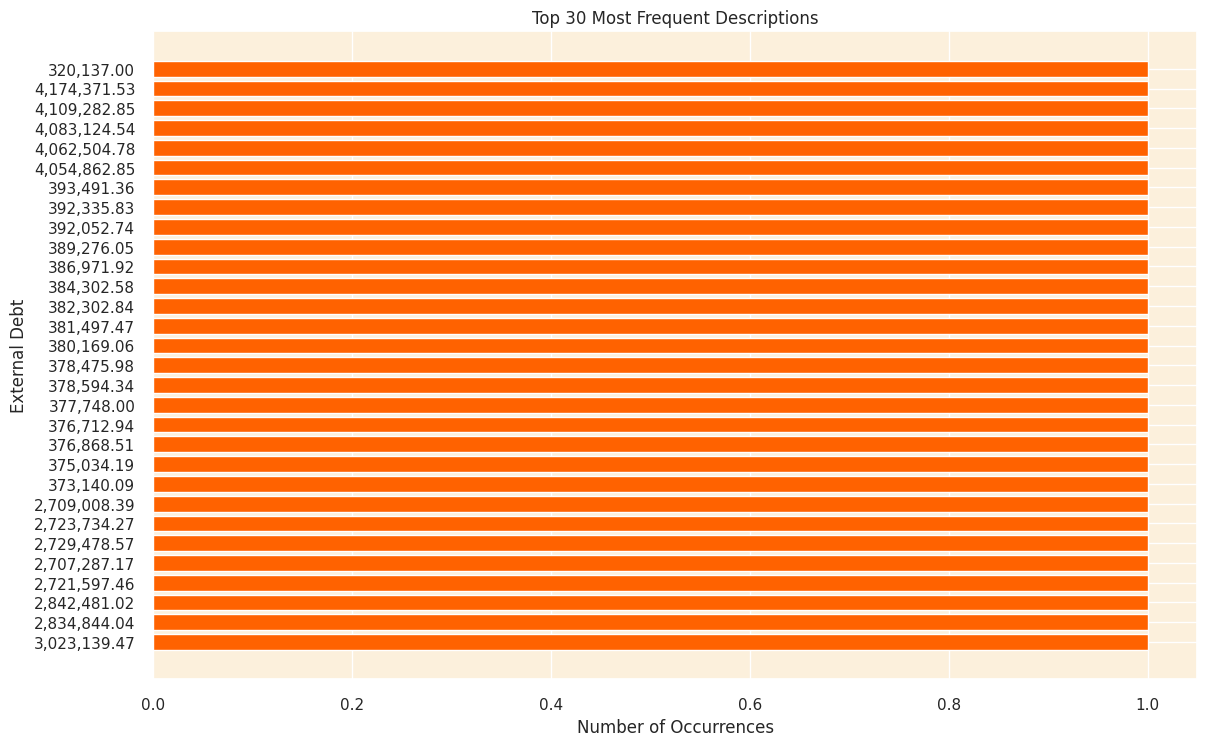

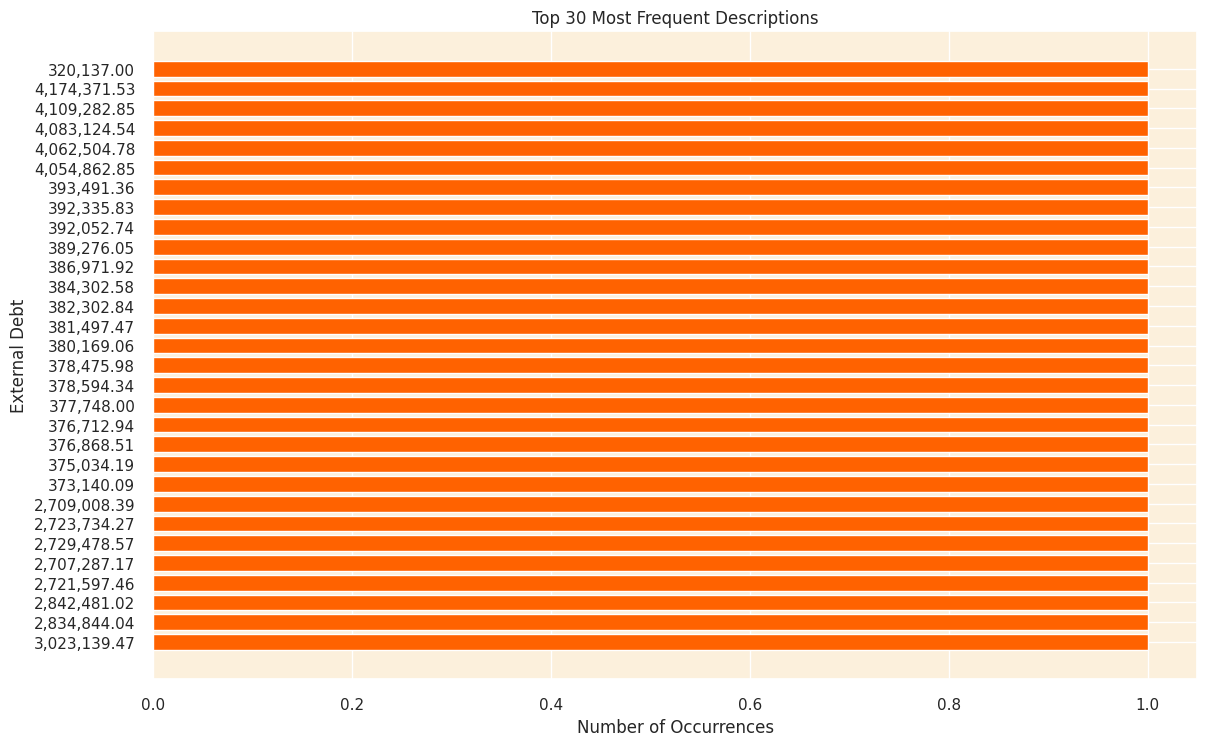

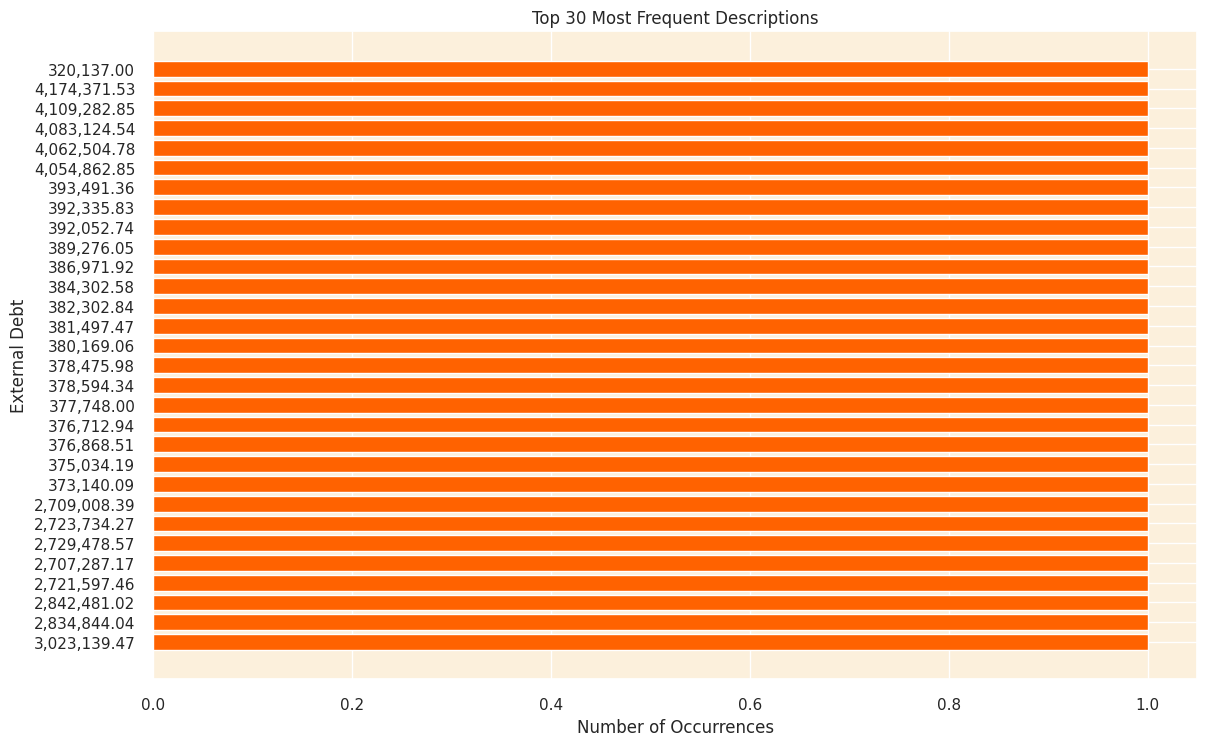

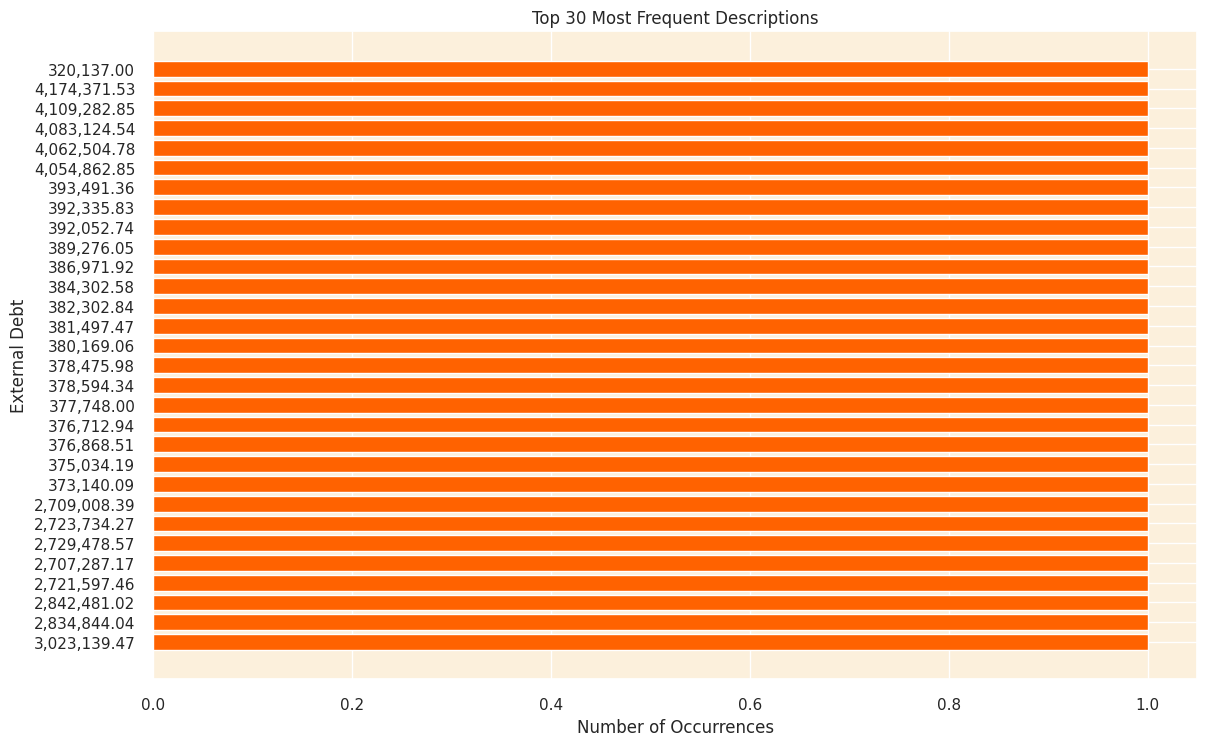

In [ ]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['External Debt'].value_counts()
# Calculate the occurrence of each unique description and sort them
description_counts = df['External Debt'].value_counts()
# Calculate the occurrence of each unique description and sort them
description_counts = df['External Debt'].value_counts()
# Calculate the occurrence of each unique description and sort them
description_counts = df['External Debt'].value_counts()

# Get the top 30 descriptions
top_30_External_Debt = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_External_Debt.index[::-1], top_30_External_Debt.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('External Debt')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()
plt.figure(figsize=(12,8))
plt.barh(top_30_External_Debt.index[::-1], top_30_External_Debt.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('External Debt')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()
plt.figure(figsize=(12,8))
plt.barh(top_30_External_Debt.index[::-1], top_30_External_Debt.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('External Debt')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()
plt.figure(figsize=(12,8))
plt.barh(top_30_External_Debt.index[::-1], top_30_External_Debt.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('External Debt')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [ ]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Month'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique Domestic debt containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique Domestic debt containing lowercase characters are:
------------------------------------------------------------
December
November
October
September
August
July
June
May
April
March
February
January


In [ ]:
df['Domestic Debt'].describe()

,Domestic Debt
count,262
unique,262
top,"183,417.00"
freq,1


In [ ]:
# Convert 'Domestic Debt' to numeric if it's not already
df['Domestic Debt'] = pd.to_numeric(df['Domestic Debt'], errors='coerce')

# Now, calculate descriptive statistics and access 'Domestic Debt'
df[df['Domestic Debt'] == 0].describe()[['Domestic Debt']]

,Domestic Debt
count,0.0
mean,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN
std,NaN


In [ ]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['Domestic Debt'] > 0]

In [ ]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

In [ ]:
# Getting the number of rows in the dataframe
df.shape[0]

0

In [ ]:
# Convert Month to datetime type
df['Month'] = pd.to_datetime(df['Month'])

# Convert Month to datetime and extract only the date
df['Month'] = df['Month'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('Domestic Debt')['Month'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['Month'].max()

# Convert Month to datetime type before subtraction
customer_data['Month'] = pd.to_datetime(customer_data['Month'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['Month']).dt.days

# Remove the Month column
customer_data.drop(columns=['Month'], inplace=True)

In [ ]:
customer_data.head()

,Domestic Debt,Days_Since_Last_Purchase


In [ ]:
# Convert 'Domestic Debt' to numeric if it's not already
df['Domestic Debt'] = pd.to_numeric(df['Domestic Debt'], errors='coerce')

# Find the most recent purchase date for each customer, but ensure there are valid 'Domestic Debt' values
# Check if df['Domestic Debt'] has any valid (non-NaN) values before grouping
if df['Domestic Debt'].notna().any():
    customer_data = df.groupby('Domestic Debt')['Month'].max().reset_index()
else:
    # Handle the case where 'Domestic Debt' has no valid values
    print("Warning: 'Domestic Debt' column has no valid values. Creating empty customer_data.")
    customer_data = pd.DataFrame(columns=['Domestic Debt', 'Month'])

# Find the most recent date in the entire dataset
most_recent_date = df['Month'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['Month'] = pd.to_datetime(customer_data['Month'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['Month']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['Month'], inplace=True)